In [7]:
using CSV, DataFrames, JuMP, Gurobi

In [8]:
data = CSV.read("data_route1.csv", DataFrame)

Row,stop_id,average_ons,average_offs,average_load,X,Y,Stop_ID,Stop_Name
,Int64,Float64,Float64,Float64,Float64,Float64,Int64,String
1,64,12.1179,0.0,12.4321,-71.0865,42.3297,64,NUBIAN STATION
2,1,0.492857,0.0535714,12.8571,-71.0828,42.331,1,WASHINGTON ST OPP RUGGLES ST
3,2,0.546429,0.175,13.4107,-71.0813,42.3323,2,WASHINGTON ST @ MELNEA CASS BLVD
4,6,0.246429,0.135714,13.5071,-71.0796,42.332,6,MELNEA CASS BLVD @ HARRISON AVE
5,10003,0.271429,0.235714,14.1714,-71.0762,42.3316,10003,ALBANY ST OPP RANDALL ST
6,57,3.96429,4.77857,13.3857,-71.0735,42.3338,57,MASSACHUSETTS AVE @ ALBANY ST
7,58,5.32857,3.00357,15.7393,-71.0749,42.3349,58,MASSACHUSETTS AVE @ HARRISON AVE
8,10590,2.36429,0.535714,16.9214,-71.077,42.3366,10590,MASSACHUSETTS AVE @ WASHINGTON ST
9,87,1.26786,0.857143,17.3179,-71.0804,42.3395,87,MASSACHUSETTS AVE @ TREMONT ST


In [9]:
on_data = data[:, 2]
off_data = data[:, 3]
load_data = data[:, 4]
x = data[:, 5]
y = data[:, 6]
n = length(x)

24

In [10]:
# distance matrix from x and y
dist = zeros(n, n)
for i in 1:length(x)
    for j in 1:length(x)
        dist[i, j] = sqrt((x[i] - x[j])^2 + (y[i] - y[j])^2)
    end
end
dist = Matrix(dist);

In [11]:
function bus_model(lambda)

    model = Model(Gurobi.Optimizer)
    set_attribute(model, "OutputFlag", 0)

    @variable(model, z[1:n], Bin)
    @variable(model, load[1:n] >= 0)
    @variable(model, off[1:n] >= 0)

    @constraint(model, [i in 1:n], load[i] <= 40)
    # load at bus stop j = load at bus stop j-1 + z_j * (number_go_on_at_stop_j - number_go_off_at_j-1)
    @constraint(model, load[1] == load_data[1])
    @constraint(model, load[n] <= 1)    # not sure here? equal to load_data or not?
    @constraint(model, [i in 2:n], load[i] == load[i-1] + z[i] * (on_data[i] - off[i-1]))
    # If a stop is removed, people go go off at the next available stop off_j = off_data_j + (1-z_{j-1})*off_j-1
    @constraint(model, off[1] == off_data[1])
    @constraint(model, [i in 2:n], off[i] == off_data[i] + (1-z[i-1]) * off[i-1])
    # bus has to stop at first and last stop
    @constraint(model, z[1] == 1)
    @constraint(model, z[n] == 1)

    # CO2 consumption is sum(load[i] * distance to go from i to i+1) + (penalty if bus stops at stop i)
    @objective(model, Max, lambda * sum(z[i] * on_data[i] for i in 1:n) - (1 - lambda) * (sum(load[i] * dist[i, i+1] for i in 1:n-1) + sum(z[i] for i in 1:n)))

    optimize!(model);

    return z, load, off, objective_value(model)
end

bus_model (generic function with 1 method)

In [12]:
z, load, off, _ = bus_model(0.5);

z_opt = value.(z)
# how many 0 values?
println("Number of stops: ", sum(z_opt))
println(z_opt)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Number of stops: 11.0


[1.0, -0.0, -0.0, -0.0, -0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 1.0]


In [13]:
load_opt = value.(load)
println("Load at each stop: ", load_opt)
off_opt = value.(off)
println("Number of people going off at each stop: ", off_opt)

Load at each stop: [12.4321428571429, 12.4321428571429, 12.4321428571429, 12.4321428571429, 12.4321428571429, 15.796428571428596, 15.746428571428577, 15.10714285714283, 15.839285714285769, 17.57142857142872, 15.707142857143165, 15.892857142857338, 19.12500000000006, 17.421428571428475, 17.42142857142827, 17.421428571428155, 17.42142857142805, 17.421428571427903, 17.421428571427832, 17.421428571427743, 17.421428571427665, 17.421428571427583, 17.421428571427516, 0.5857142857129282]
Number of people going off at each stop: [0.0, 0.0535714285714286, 0.2285714285714286, 0.3642857142857146, 0.6000000000000006, 5.378571428571432, 3.00357142857143, 0.5357142857142847, 0.8571428571428559, 3.74642857142857, 1.428571428571427, 1.478571428571426, 3.0, 0.29285714285714093, 3.0, 4.660714285714295, 6.239285714285748, 11.700000000000076, 12.607142857142964, 13.196428571428712, 13.960714285714456, 15.375000000000199, 16.83571428571453, 23.91428571428596]


In [14]:
current_co2 = sum(load_data[i] * dist[i, i+1] for i in 1:n-1) + n
model_co2 = sum(load_opt[i] * dist[i, i+1] for i in 1:n-1) + sum(z_opt[i] for i in 1:n)
current_profit = sum(on_data[i] for i in 1:n)
model_profit = sum(z_opt[i] * on_data[i] for i in 1:n)

println("Current CO2 emissions: ", sum(load_data[i] * dist[i, i+1] for i in 1:n-1) + n)
println("With our model: ", sum(load_opt[i] * dist[i, i+1] for i in 1:n-1) + sum(z_opt[i] for i in 1:n))
# % reduction (keep 1 decimal)
println("CO2 reduction: ", round((current_co2 - model_co2) / current_co2 * 100, digits=1), "%")

println('\n')

println("Current profit: ", sum(on_data[i] for i in 1:n))
println("With our model: ", sum(z_opt[i] * on_data[i] for i in 1:n))
# % increase
println("Profit decrease: ", round((model_profit - current_profit) / current_profit * 100, digits=1), "%")


Current CO2 emissions: 25.130346439292182
With our model: 12.22133132603267


CO2 reduction: 51.4%


Current profit: 43.54285714285707
With our model: 

37.13571428571423
Profit decrease: -14.7%


In [15]:
lambda_values = 0:0.05:1
co2_values = zeros(length(lambda_values))
profit_values = zeros(length(lambda_values))
nb_stops = zeros(length(lambda_values))
for i in 1:length(lambda_values)
    z, load, off, _ = bus_model(lambda_values[i])
    z_opt = value.(z)
    load_opt = value.(load)
    off_opt = value.(off)
    co2_values[i] = sum(load_opt[i] * dist[i, i+1] for i in 1:n-1) + sum(z_opt[i] for i in 1:n)
    profit_values[i] = sum(z_opt[i] * on_data[i] for i in 1:n)
    nb_stops[i] = sum(z_opt)
end

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12

In [16]:
profit_values

21-element Vector{Float64}:
 23.789285714285676
 23.789285714285676
 23.789285714285693
 23.789285714285676
 25.52499999999995
 32.957142857142806
 32.957142857142806
 32.957142857142806
 34.57142857142852
 37.13571428571423
  ⋮
 40.3607142857143
 40.360714285714195
 40.85357142857137
 40.85357142857144
 41.62142857142852
 41.62142857142853
 41.62142857142851
 41.82499999999993
 41.82499999999993

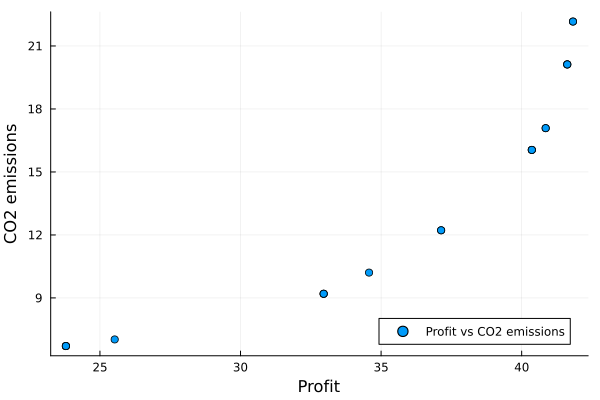

In [17]:
# plot co2 values and profit values
using Plots
plot(profit_values, co2_values, xlabel="Profit", ylabel="CO2 emissions", label="Profit vs CO2 emissions", legend=:bottomright, seriestype=:scatter)

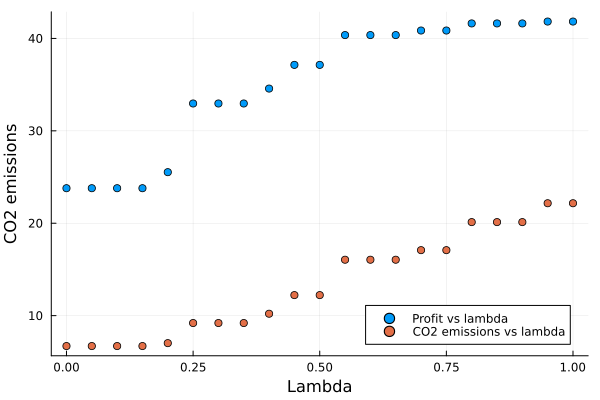

In [18]:
# plot profit vs lambda and co2 vs lambda on the same plot
plot(lambda_values, profit_values, xlabel="Lambda", ylabel="Profit", label="Profit vs lambda", legend=:bottomright, seriestype=:scatter)
plot!(lambda_values, co2_values, xlabel="Lambda", ylabel="CO2 emissions", label="CO2 emissions vs lambda", legend=:bottomright, seriestype=:scatter)

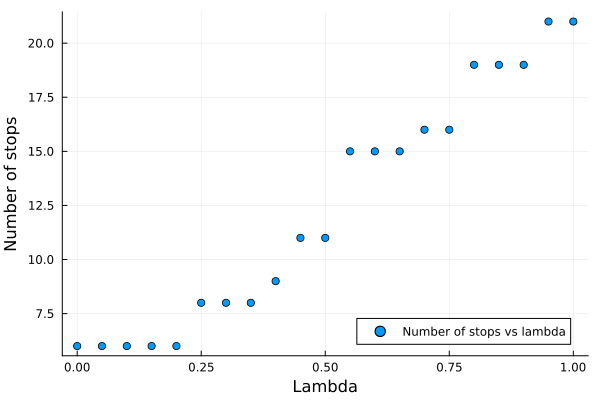

In [19]:
# plot number of stops vs lambda
plot(lambda_values, nb_stops, xlabel="Lambda", ylabel="Number of stops", label="Number of stops vs lambda", legend=:bottomright, seriestype=:scatter)

## With time periods

In [21]:
data = CSV.read("data_route1_time_periods.csv", DataFrame)

Row,stop_id,average_ons,average_offs,average_load,time_period_id,X,Y,Stop_ID,Stop_Name
,Int64,Float64,Float64,Float64,String15,Float64,Float64,Int64,String
1,64,12.9,0.0,12.94,time_period_03,-71.0865,42.3297,64,NUBIAN STATION
2,64,2.58,0.0,2.66,time_period_09,-71.0865,42.3297,64,NUBIAN STATION
3,64,6.6307,0.0,6.75263,time_period_10,-71.0865,42.3297,64,NUBIAN STATION
4,64,2.95556,0.0,3.15556,time_period_08,-71.0865,42.3297,64,NUBIAN STATION
5,64,12.1179,0.0,12.4321,time_period_04,-71.0865,42.3297,64,NUBIAN STATION
6,64,3.75455,0.0,3.93182,time_period_07,-71.0865,42.3297,64,NUBIAN STATION
7,64,10.5647,0.0,10.9706,time_period_05,-71.0865,42.3297,64,NUBIAN STATION
8,64,6.80617,0.0,6.88395,time_period_11,-71.0865,42.3297,64,NUBIAN STATION
9,64,6.5875,0.0,6.75,time_period_06,-71.0865,42.3297,64,NUBIAN STATION


In [22]:
# {'time_period_01': 'VERY_EARLY_MORNING', 'time_period_02': 'EARLY_AM', 'time_period_03': 'AM_PEAK', 'time_period_04': 'MIDDAY_BASE', 'time_period_05': 'MIDDAY_SCHOOL', 'time_period_06': 'PM_PEAK', 'time_period_07': 'EVENING', 'time_period_08': 'LATE_EVENING', 'time_period_09': 'NIGHT', 'time_period_10': 'OFF_PEAK', 'time_period_11': 'OFF_PEAK'}

In [23]:
data_matrix = []
for i in 1:11
    if i >= 10
        time_period = "time_period_" * string(i)
    else
        time_period = "time_period_0" * string(i)
    end
    # subset of data when time_period_id is time_period_i
    data_subset = data[data[!, "time_period_id"] .== time_period, :]
    data_subset = Matrix(data_subset)
    push!(data_matrix, data_subset)
end


In [24]:
data_matrix

11-element Vector{Any}:
 Any[64 10.375 … 64 "NUBIAN STATION"; 1 0.15 … 1 "WASHINGTON ST OPP RUGGLES ST"; … ; 109 0.0 … 109 "MASSACHUSETTS AVE @ BOW ST"; 110 0.0 … 110 "MASSACHUSETTS AVE @ HOLYOKE ST"]
 Any[64 10.7 … 64 "NUBIAN STATION"; 1 0.1 … 1 "WASHINGTON ST OPP RUGGLES ST"; … ; 109 0.0 … 109 "MASSACHUSETTS AVE @ BOW ST"; 110 0.0 … 110 "MASSACHUSETTS AVE @ HOLYOKE ST"]
 Any[64 12.9 … 64 "NUBIAN STATION"; 1 0.246666666666667 … 1 "WASHINGTON ST OPP RUGGLES ST"; … ; 109 0.0266666666666667 … 109 "MASSACHUSETTS AVE @ BOW ST"; 110 0.0 … 110 "MASSACHUSETTS AVE @ HOLYOKE ST"]
 Any[64 12.1178571428571 … 64 "NUBIAN STATION"; 1 0.492857142857143 … 1 "WASHINGTON ST OPP RUGGLES ST"; … ; 109 0.025 … 109 "MASSACHUSETTS AVE @ BOW ST"; 110 0.0 … 110 "MASSACHUSETTS AVE @ HOLYOKE ST"]
 Any[64 10.5647058823529 … 64 "NUBIAN STATION"; 1 0.447058823529412 … 1 "WASHINGTON ST OPP RUGGLES ST"; … ; 109 0.0764705882352941 … 109 "MASSACHUSETTS AVE @ BOW ST"; 110 0.0 … 110 "MASSACHUSETTS AVE @ HOLYOKE ST"]
 Any[

In [25]:
# create on_data matrix with one column for each time period
on_data_matrix = zeros(n, 11)
for i in 1:11
    on_data_matrix[:, i] = data_matrix[i][:, 2]
end

# create off_data matrix with one column for each time period
off_data_matrix = zeros(n, 11)
for i in 1:11
    off_data_matrix[:, i] = data_matrix[i][:, 3]
end

load_data_matrix = zeros(n, 11)
for i in 1:11
    load_data_matrix[:, i] = data_matrix[i][:, 4]
end

x = data_matrix[1][:, 5]
y = data_matrix[1][:, 6]
n = length(x)

p = 11

11

In [26]:
function bus_model_time_periods(lambda)

    M = 1000

    model = Model(Gurobi.Optimizer)
    set_attribute(model, "OutputFlag", 0)

    @variable(model, z[1:n, 1:p], Bin)
    @variable(model, load[1:n, 1:p] >= 0)
    @variable(model, off[1:n, 1:p] >= 0)
    @variable(model, y[1:p, 1:4], Bin)
    @variable(model, s[1:p, 1:4], Bin) # if s_tj = 1, then y_tj + y_t+1,j + y_t_2,j + y_t+3,j = 1

    @constraint(model, [i in 1:n, t in 1:p], load[i, t] <= 40)
    # load at bus stop j = load at bus stop j-1 + z_j * (number_go_on_at_stop_j - number_go_off_at_j-1)
    @constraint(model, [t in 1:p], load[1, t] == load_data_matrix[1, t])
    @constraint(model, [t in 1:p], load[n, t] <= 1)
    @constraint(model, [i in 2:n, t in 1:p], load[i, t] == load[i-1, t] + z[i, t] * (on_data_matrix[i, t] - off[i-1, t]))
    # If a stop is removed, people go go off at the next available stop off_j = off_data_j + (1-z_{j-1})*off_j-1
    @constraint(model, [t in 1:p], off[1, t] == off_data_matrix[1, t])
    @constraint(model, [i in 2:n, t in 1:p], off[i, t] == off_data_matrix[i, t] + (1-z[i-1, t]) * off[i-1, t])
    # bus has to stop at first and last stop
    @constraint(model, [t in 1:p], z[1, t] == 1)
    @constraint(model, [t in 1:p], z[n, t] == 1)
    # time periods constraints: group time periods into 4 groups (must be consecutive) because we dont want to change stops too often
    @constraint(model, sum(y[t, 1] for t in 1:p) == 3)
    @constraint(model, sum(y[t, 2] for t in 1:p) == 3)
    @constraint(model, sum(y[t, 3] for t in 1:p) == 3)
    @constraint(model, sum(y[t, 4] for t in 1:p) == 2)
    @constraint(model, [t in 1:p], sum(y[t, j] for j in 1:4) == 1)  # each time period is in exactly one group
    # @constraint(model, [t in 1:p, j in 1:4], s[t, j] <= y[t, j])
    # @constraint(model, [t in 1:p, j in 1:4], s[t, j] <= y[t%11 + 1, j])
    # @constraint(model, [t in 1:p, j in 1:4], s[t, j] <= y[(t+1)%11 + 1, j])
    @constraint(model, [t in 1:p, j in 1:3], 3*s[t, j] <= y[t, j] + y[t%11 + 1, j] + y[(t+1)%11 + 1, j])
    @constraint(model, [t in 1:p], 2*s[t, 4] <= y[t, 4] + y[t%11 + 1, 4])
    @constraint(model, [j in 1:4], sum(s[t, j] for t in 1:p) == 1)
    @constraint(model, [i in 1:n, t in 1:p, k in 1:p, j in 1:4], z[i, t] <= z[i, k] + M*(2 - y[t, j] - y[k, j])) # if time t and k are in the same group, then z[i, t] <= z[i, k]
    @constraint(model, [i in 1:n, t in 1:p, k in 1:p, j in 1:4], z[i, t] >= z[i, k] - M*(2 - y[t, j] - y[k, j])) # if time t and k are in the same group, then z[i, t] >= z[i, k]

    # CO2 consumption is sum(load[i] * distance to go from i to i+1) + (penalty if bus stops at stop i)
    @objective(model, Max, lambda * sum(z[i, t] * on_data_matrix[i, t] for i in 1:n for t in 1:p) - (1 - lambda) * (sum(load[i, t] * dist[i, i+1] for i in 1:n-1 for t in 1:p) + sum(z[i, t] for i in 1:n for t in 1:p)))

    optimize!(model);

    return z, load, off, y, s, objective_value(model)
end

bus_model_time_periods (generic function with 1 method)

In [27]:
load_data_matrix[1, :]

11-element Vector{Float64}:
 10.45
 10.7142857142857
 12.94
 12.4321428571429
 10.9705882352941
  6.75
  3.93181818181818
  3.15555555555556
  2.66
  6.75263157894737
  6.88395061728395

In [28]:
z, load, off, y, s, _ = bus_model_time_periods(0.5);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12


In [29]:
Int.(value.(y))

11×4 Matrix{Int64}:
 0  0  1  0
 0  0  1  0
 0  0  0  1
 0  0  0  1
 0  1  0  0
 0  1  0  0
 0  1  0  0
 1  0  0  0
 1  0  0  0
 1  0  0  0
 0  0  1  0

In [30]:
Int.(value.(z))

24×11 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  1  1  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  0  0  0  0  0  0  1
 1  1  1  1  0  0  0  0  0  0  1
 1  1  1  1  1  1  1  1  1  1  1
 ⋮              ⋮              ⋮
 0  0  1  1  0  0  0  0  0  0  0
 0  0  1  1  1  1  1  0  0  0  0
 0  0  0  0  1  1  1  0  0  0  0
 0  0  0  0  1  1  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  1  1  0  0  0  0
 1  1  1  1  1  1  1  1  1  1  1

In [31]:
lambda_values = 0:0.5:1
[lambda_values[i] for i in 1:length(lambda_values)]

3-element Vector{Float64}:
 0.0
 0.5
 1.0

In [32]:
lambda_values = 0:0.5:1
co2_values = zeros(length(lambda_values))
profit_values = zeros(length(lambda_values))
nb_stops = zeros(length(lambda_values))
for i in 1:length(lambda_values)
    println(i)
    z, load, off, y, s, _ = bus_model_time_periods(lambda_values[i])
    z_opt = Int.(value.(z))
    load_opt = value.(load)
    off_opt = value.(off)
    co2_values[i] = sum(load_opt[i, t] * dist[i, i+1] for i in 1:n-1 for t in 1:p) + sum(z_opt[i, t] for i in 1:n for t in 1:p)
    profit_values[i] = sum(z_opt[i, t] * on_data_matrix[i, t] for i in 1:n for t in 1:p)
end

1


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
2


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12
3


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-12


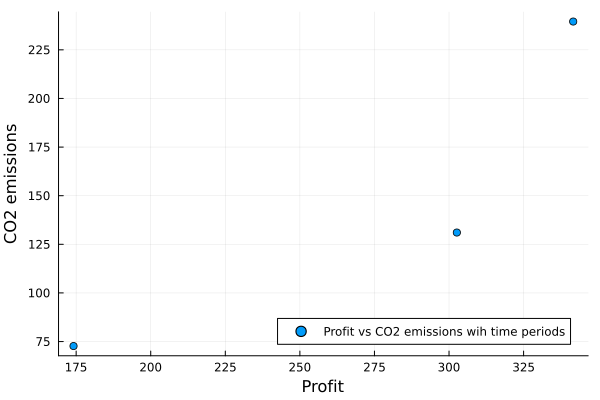

In [33]:
plot(profit_values, co2_values, xlabel="Profit", ylabel="CO2 emissions", label="Profit vs CO2 emissions wih time periods", legend=:bottomright, seriestype=:scatter)